# Supplement A
# Microwave Radiometer Temperature and Humidity Retrieval

In the following, we introduce the use of the pyOptimalEstimation Python library using a standard temperature and humidity retrieval using a microwave radioemetr (MWR, Rose et al 2005). We use the simple forward operator introduced by Löhnert et al. (2004) which does not account for scattering by hydrometeors. The prior is estimated based on almost 16 years of spring (March - May) radiosonde observations at the U.S. Department of Energy Atmospheric Radiation Measurement (ARM) program at the North Slope of Alaska (NSA) site in Utqiagvik (Barrow), Alaska. 

All grey code blocks (cells) in this example can be modified for playing around. Each cell is executed with *shift+enter*. If you have never used Jupyter notebooks before, we recommend to check out the official tutorial: https://mybinder.org/v2/gh/ipython/ipython-in-depth/master?filepath=binder/Index.ipynb


# Preparation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

Before we start, we need to load all required Python libraries

In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr

import pyOptimalEstimation as pyOE

We put some helper routines and the radiative transfer model in a separate file which we load with 

In [2]:
sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

# Load data
The mean $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the prior have been estimated from the NSA radiosonde data set and are loaded from a NetCDF file. Additionally, the forward operator requires also the height profile and the associated pressure levels. The unit of temperature is Kelvin and specific humidity is provided as $\log_{10}$(g/kg)

In [3]:
allData = xr.open_dataset('data/radiosonde_prior.nc')

x_mean = allData['x_mean']
x_cov = allData['x_cov']
pressure = allData['pressure']
height = allData['height']

The file also contained some atmospheric profiles that were not used to estimate the prior. We will use them to estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true atmospheric state. For this example we use the atmospheric profile at Barrow at 2006-04-01T00:00:00

In [4]:
profile = np.datetime64('2006-04-01T00:00:00')
season = 'MAM'  #Spring: March April May
x_truth = allData['x_truth'].sel(time=profile)


In [5]:
allData['x_mean']

<xarray.DataArray 'x_mean' (season: 5, state: 120)>
array([[ 1.505125e-01,  2.635610e+02,  1.813772e-01, ...,  2.226630e+02,
        -2.137824e+00,  2.234241e+02],
       [-3.316486e-01,  2.506143e+02, -2.533067e-01, ...,  2.199408e+02,
        -2.254896e+00,  2.214870e+02],
       [-3.998277e-02,  2.581431e+02,  5.348527e-03, ...,  2.234091e+02,
        -2.137710e+00,  2.230997e+02],
       [ 6.319935e-01,  2.771043e+02,  6.156259e-01, ...,  2.271071e+02,
        -1.965280e+00,  2.275550e+02],
       [ 3.163274e-01,  2.676885e+02,  3.289200e-01, ...,  2.189339e+02,
        -2.339660e+00,  2.183340e+02]], dtype=float32)
Coordinates:
  * state    (state) object '00008_q' '00008_t' ... '22508_q' '22508_t'
  * season   (season) object 'all' 'DJF' 'MAM' 'JJA' 'SON'

We use the standard frequencies in GHz of an HATPRO microwave radiometer (Rose et al 2005)

In [6]:
frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

# Define forward operator

Next, we define the forward operator. pyOptimalEstimation requires that the state vector $\mathbf{x}$ is the first argument of the forward operator function and the measurement vector $\mathbf{y}$ is returned. All the magic is handled by the nonScatMWRadTran library (Löhnert et al. 2004), the function `forwardRT` is for converting it to the correct SI units. 

In [7]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

See the file nonScatMWRadTran.py for the actual forward operator code which| is in detail described in Löhnert et al. (2004).

# Run reference retrieval

## Prepare retrieval
First, we need names for our Y and X variables to avoid any confusion. For $\mathbf{y}$, we select the frequencies, for $\mathbf{x}$ we use a string containing the height in meters and the variable name (t or q). 

In [8]:
y_vars = np.array(frequencies)
x_vars = x_mean.state.values
print('y_vars:\n', y_vars)
print('x_vars:\n', x_vars)

y_vars:
 [22.24 23.04 23.84 25.44 26.24 27.84 31.4  51.26 52.28 53.86 54.94 56.66
 57.3  58.  ]
x_vars:
 ['00008_q' '00008_t' '00107_q' '00107_t' '00207_q' '00207_t' '00308_q'
 '00308_t' '00408_q' '00408_t' '00508_q' '00508_t' '00608_q' '00608_t'
 '00707_q' '00707_t' '00807_q' '00807_t' '00907_q' '00907_t' '01007_q'
 '01007_t' '01107_q' '01107_t' '01207_q' '01207_t' '01307_q' '01307_t'
 '01407_q' '01407_t' '01507_q' '01507_t' '01607_q' '01607_t' '01707_q'
 '01707_t' '01807_q' '01807_t' '01907_q' '01907_t' '02007_q' '02007_t'
 '02107_q' '02107_t' '02207_q' '02207_t' '02307_q' '02307_t' '02407_q'
 '02407_t' '02507_q' '02507_t' '02607_q' '02607_t' '02707_q' '02707_t'
 '02807_q' '02807_t' '02907_q' '02907_t' '03007_q' '03007_t' '03107_q'
 '03107_t' '03207_q' '03207_t' '03307_q' '03307_t' '03407_q' '03407_t'
 '03507_q' '03507_t' '03757_q' '03757_t' '04007_q' '04007_t' '04257_q'
 '04257_t' '04507_q' '04507_t' '04758_q' '04758_t' '05008_q' '05008_t'
 '05508_q' '05508_t' '06008_q' '06008_t' '0

The measurement uncertainty ($\mathbb{S}_y$) is defined by using standard estimates for the channel uncertainties. For now, we assume that covariances between the channels can be neglected, i.e. $\mathbb{S}_y$ is a diagonal matrix.

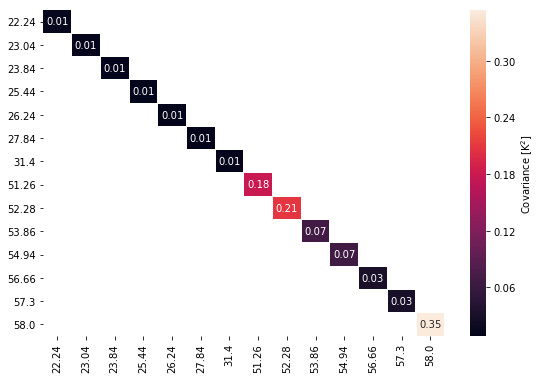

In [9]:
# y_noise = pn.Series(
#     [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7, 0.5, 0.5, 0.3, 0.3, 0.3],
#     index=y_vars)
y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_y.where(S_y > 0), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)


And the prior $\mathbb{S}_a$ is obtained from the mean and Covariance matrix of the prior data set. We plot them separately for T and q. Note how the Tropopause can be clearly seen around 10 km.

Text(0.5, 1.0, '$\\mathbb{S}_{a}$ Humidity')

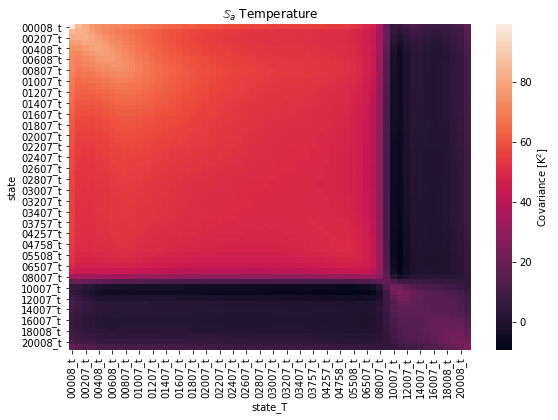

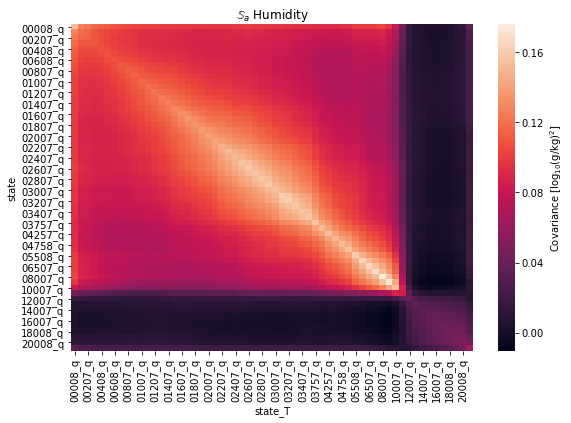

In [10]:
x_a = x_mean.sel(season=season).to_pandas()[x_vars]
S_a = x_cov.sel(season=season).to_pandas().loc[x_vars, x_vars]

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Temperature')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Humidity')

It is crucial that $\mathbb{S}_a$ and $\mathbb{S}_y$ can be inverted. In case of problems, the user can try switching units because small values can cause issues with numerical stability. 

Note: Numpy's `np.linalg.inv` does not check for singular matrices. Therefore, it is recommended to use pyOptimalEstimation's `pyOE.invertMatrix` function which checks for matrix singularity.

In [11]:
pyOE.invertMatrix(S_a)

array([[ 1.47514712e+03, -5.64362676e+01, -4.14750390e+02, ...,
        -1.78369398e+00, -3.62929572e+01,  4.86651166e+00],
       [-5.64362676e+01,  2.31023667e+00,  1.51926406e+01, ...,
         9.94946371e-02,  9.60070764e-01, -2.10648197e-01],
       [-4.14750390e+02,  1.51926406e+01,  1.04110568e+03, ...,
        -5.08554788e-01,  1.70546253e+01, -1.36091968e+00],
       ...,
       [-1.78369398e+00,  9.94946371e-02, -5.08554788e-01, ...,
         1.91561636e+00,  5.91701318e+00, -4.71448593e-01],
       [-3.62929572e+01,  9.60070764e-01,  1.70546253e+01, ...,
         5.91701318e+00,  1.21295339e+02, -5.76084764e+00],
       [ 4.86651166e+00, -2.10648197e-01, -1.36091968e+00, ...,
        -4.71448593e-01, -5.76084764e+00,  5.14386372e-01]])

Based on the true profile, we create a synthetic observation. Auxiliary data which needs to be passed on to the `forwardRT` function is stored in the `forwardKwArgs` dictionary. The `**forwardKwArgs` notation passes all dictonary elements of `forwardKwArgs` as named function parameters.

In [12]:
forwardKwArgs = dict(
    pressure=pressure.sel(season=season),
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth.to_pandas(), **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

The resulting brightness temperatures are storted in `y_obs`

In [13]:
y_obs

22.24     14.465517
23.04     13.995871
23.84     12.693847
25.44     11.038715
26.24     10.732210
27.84     10.687470
31.40     11.939956
51.26    105.124614
52.28    143.715403
53.86    230.364095
54.94    251.509452
56.66    250.602579
57.30    250.071957
58.00    249.692744
dtype: float64

Using `pyOptimalEstimation`, we combine all information into an object named `oe_ref`.

In [14]:
oe_ref = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth.to_pandas(),
    forwardKwArgs=forwardKwArgs,
)

## Run retrieval
The reference run using a prior based on December, January and February radiosondes. 

In [15]:
oe_ref.doRetrieval()
chiSquareTest = oe_ref.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

4.28 s, iteration 1, degrees of freedom: 4.71 of 120. convergence criteria NOT fullfilled  1014.185
6.49 s, iteration 2, degrees of freedom: 4.67 of 120. convergence criteria NOT fullfilled  25.998
8.93 s, iteration 3, degrees of freedom: 4.67 of 120. convergence criteria fullfilled  0.133
11.38 s, iteration 4, degrees of freedom: 4.67 of 120.  Done.  0.000
Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


## Analyze the results
`pyOptimalEstimation` provides a toolset of functions to asses model quality as introduced below. We encourage teh reader to look at the documentation with `help(oe_ref)` or `oe_ref?` 

In [16]:
help(oe_ref)

Help on optimalEstimation in module pyOptimalEstimation.pyOEcore object:

class optimalEstimation(builtins.object)
 |  The core optimalEstimation class, which contains all required parameters.
 |  
 |  Parameters
 |  ----------
 |  x_vars : list of str
 |      names of the elements of state vector x.
 |  x_a : pd.Series or list or np.ndarray
 |      prior information of state x.
 |  S_a : pd.DataFrame or list or np.ndarray
 |      covariance matrix of state x.
 |  y_vars : list of str
 |      names of the elements of state vector x
 |  y_obs : pd.Series or list or np.ndarray
 |      observed measurement vector y.
 |  S_y : pd.DataFrame or list or np.ndarray
 |      covariance matrix of measurement y. If there is no b vector, S_y
 |      is sequal to S_e
 |  forward : function
 |      forward model expected as ``forward(xb,**forwardKwArgs): return y``
 |      with xb = pd.concat((x,b)).
 |  x_truth : pd.Series or list or np.ndarray, optional
 |      If truth of state x is known, it can 

### Iterations
The function `plotIterations` visualizes the itrations of `pyOptimalEstimation` to the estimated result on the x axis: Iteration 0 is the first guess (in our case the prior), the solid line at iteration 2 is where the retrieval converges. $\mathbf{x}_{truth}$ (first panel) and $\mathbf{y}_{obs}$ (second panel) are on the very right. The degrees of freedom (describing the number of independent information pieces obtained) and the convergence criterion (see Sec. 5.6.2 of Rodgers, 2000) are displayed int the third and fourth panel, respectively.

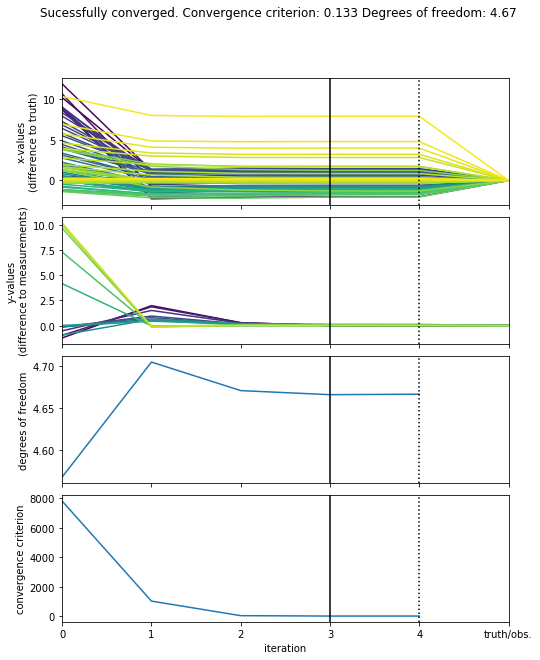

In [17]:
fig = oe_ref.plotIterations(legend=False, mode='difference')

### Profiles
The optimal solution $\mathbf{x}_{optimal}$ can be accessed with 

In [18]:
oe_ref.x_op

00008_q     -0.406135
00008_t    249.002329
00107_q     -0.380221
00107_t    248.452024
00207_q     -0.363872
00207_t    248.294208
00308_q     -0.348827
00308_t    249.238030
00408_q     -0.337260
00408_t    250.490945
00508_q     -0.320610
00508_t    251.672697
00608_q     -0.289281
00608_t    252.990886
00707_q     -0.266166
00707_t    254.110426
00807_q     -0.262945
00807_t    254.991008
00907_q     -0.246178
00907_t    255.754758
01007_q     -0.232916
01007_t    256.421922
01107_q     -0.229891
01107_t    256.839280
01207_q     -0.228790
01207_t    257.171413
01307_q     -0.228472
01307_t    257.436398
01407_q     -0.210215
01407_t    257.641902
              ...    
07007_q     -0.888300
07007_t    229.189343
08007_q     -1.253285
08007_t    222.756796
09007_q     -1.605786
09007_t    218.507654
10007_q     -1.994312
10007_t    217.923971
11007_q     -2.270618
11007_t    219.476207
12007_q     -2.406767
12007_t    221.412751
13007_q     -2.412446
13007_t    222.206029
14007_q   

and the according posterior correlation $\mathbb{S}_{optimal}$ is accesible as `oe_ref.S_op ` 

Text(0.5, 1.0, '$\\mathbb{S}_{optimal}$ Humidity')

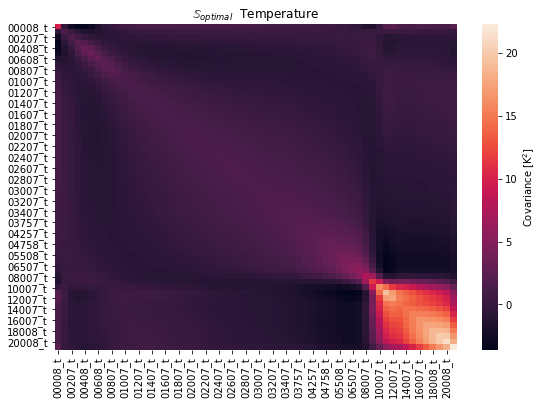

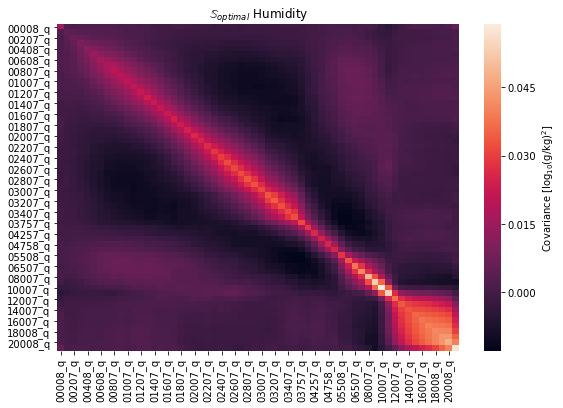

In [19]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{optimal}$  Temperature')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{optimal}$ Humidity')

The square of the diagonal of are the uncertanties of the optimal solution which can be also found in 

In [20]:
oe_ref.x_op_err

00008_q    0.126511
00008_t    3.125282
00107_q    0.070245
00107_t    1.230067
00207_q    0.079873
00207_t    1.260222
00308_q    0.096746
00308_t    1.577811
00408_q    0.108868
00408_t    1.775551
00508_q    0.121020
00508_t    1.856372
00608_q    0.129784
00608_t    1.737184
00707_q    0.135304
00707_t    1.590892
00807_q    0.142298
00807_t    1.506774
00907_q    0.143158
00907_t    1.365099
01007_q    0.143345
01007_t    1.278578
01107_q    0.147477
01107_t    1.245865
01207_q    0.149138
01207_t    1.207402
01307_q    0.154277
01307_t    1.210161
01407_q    0.150133
01407_t    1.204583
             ...   
07007_q    0.203030
07007_t    2.375334
08007_q    0.221955
08007_t    2.771506
09007_q    0.230324
09007_t    3.382150
10007_q    0.242348
10007_t    4.014123
11007_q    0.233183
11007_t    4.411158
12007_q    0.191671
12007_t    4.201254
13007_q    0.183755
13007_t    3.811021
14007_q    0.182271
14007_t    3.815260
15007_q    0.189136
15007_t    3.935313
16007_q    0.194446


Using a specific helper routine, we plot the result as vertical profiles of temperature and humidity.

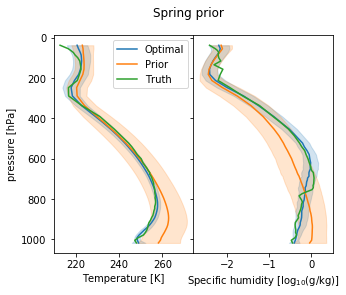

In [21]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='Spring prior')

### Root mean square error
Estimate the root mean square error (RMS) for X and Y.

In [22]:
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]


### Statistical tests

`chiSquareTest()` makes a range of statistical tests whether:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior $\mathbb{S}_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 


In [23]:
chiSquareTest = oe_ref.chiSquareTest(significance=0.05)
print('\nTests passed:\n' ,chiSquareTest[0])

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       

Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


### Linearity tests
`testLinearity()` tests whether the problem is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`). In case $\mathbf{x}_{truth}$ is  unknown, error patterns of $\mathbb{S}$ can be used instead (`linearity`). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. 

In [24]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_ref.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  True


# Run modified retrieval
In the following, we modify the retrieval in various ways and asses the impact on retrieval quality. The reader is strongly encouraged to play around with the various parameters. 

## Use all seasons for prior instead of spring only
Use prior based on all seasons. The retrieval still converges after two interatiosn with a similar degrees of freedom value.

In [25]:
x_a = x_mean.sel(season='all').to_pandas()
S_a = x_cov.sel(season='all').to_pandas()

oe_all = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_all.doRetrieval()

7.16 s, iteration 1, degrees of freedom: 4.72 of 120. convergence criteria NOT fullfilled  797.415
9.47 s, iteration 2, degrees of freedom: 4.69 of 120. convergence criteria NOT fullfilled  32.232
11.32 s, iteration 3, degrees of freedom: 4.69 of 120. convergence criteria fullfilled  0.311
13.53 s, iteration 4, degrees of freedom: 4.69 of 120.  Done.  0.001


True

### Profiles

At first sight, the retrieved profiles look similar

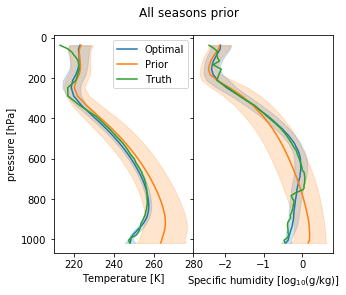

In [26]:

fig = supporting_routines.plotMwrResults(
    oe_all,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='All seasons prior')


### Statistical tests
All $\chi^2$ tests pass

In [27]:
print(oe_all.chiSquareTest()[0])

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation     True
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior           True
dtype: bool


### Root mean square error
But the RMS values for $\mathbf{x}$ are enhanced with respect to the reference run:

In [28]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('All seasons prior:')
supporting_routines.print_mwr_rms(oe_all)

Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
All seasons prior:
RMS X Temperature: 2.02984 [K]
RMS X Humidity: 0.14444 [log$_{10}$(g/kg)]
RMS Y 0.0358779 [K]


Interestingly, the RMS for $\mathbf{y}$ is reduced highlighting the ambiguity of the retrieval problem.

## Use summer  instead of spring for prior


Use summer prior instead of winter

In [29]:
x_a = x_mean.sel(season='JJA').to_pandas()
S_a = x_cov.sel(season='JJA').to_pandas()

oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_sum.doRetrieval()


7.09 s, iteration 1, degrees of freedom: 4.62 of 120. convergence criteria NOT fullfilled  7269.663
10.62 s, iteration 2, degrees of freedom: 4.52 of 120. convergence criteria NOT fullfilled  411.238
12.98 s, iteration 3, degrees of freedom: 4.50 of 120. convergence criteria NOT fullfilled  9.942
15.31 s, iteration 4, degrees of freedom: 4.50 of 120. convergence criteria fullfilled  0.059
17.37 s, iteration 5, degrees of freedom: 4.50 of 120.  Done.  0.000


True

### Profiles
The retrieval needs 4 instead of 2 iterations for convergence, the optimal is clearly outside of the prior. The degrees of freedom are reduced  by only 0.2.




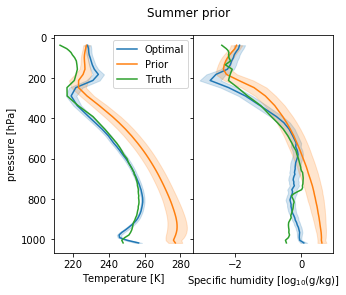

In [30]:
fig = supporting_routines.plotMwrResults(
    oe_sum,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='Summer prior')


### Root mean square error

In comparison to the reference run, the RMS is greatly enhanced

In [31]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Summer prior:')
supporting_routines.print_mwr_rms(oe_sum)

Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Summer prior:
RMS X Temperature: 5.04366 [K]
RMS X Humidity: 0.309074 [log$_{10}$(g/kg)]
RMS Y 0.145272 [K]


### Statistical tests
Most importantly, all $\chi^2$ tests clearly fail. In a real-world application where $\mathbf{x}_{truth}$ is unknown, this test can give give the user a warnign about tretrieval issues.

In [32]:
print(oe_sum.chiSquareTest()[0])

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


## Diagonal prior
Here, we investigate what happens when only diagonal vlaues in $\mathbb{S}_a$ are considered, i.e. correlations are ignored. The retrieval needs only two iterations and also the degrees of freedom are only slightly reduced.

In [33]:
x_a = x_mean.sel(season='MAM').to_pandas()
S_a = x_cov.sel(season='MAM')
S_a_diag = np.diag(np.diag(S_a))

oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a_diag,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_diag.doRetrieval()


6.23 s, iteration 1, degrees of freedom: 4.50 of 120. convergence criteria NOT fullfilled  179.076
10.33 s, iteration 2, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  11.376
14.09 s, iteration 3, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  2.229
18.23 s, iteration 4, degrees of freedom: 4.54 of 120. convergence criteria NOT fullfilled  3.202
25.17 s, iteration 5, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  1.487
30.98 s, iteration 6, degrees of freedom: 4.53 of 120. convergence criteria fullfilled  0.079
35.80 s, iteration 7, degrees of freedom: 4.53 of 120.  Done.  0.002


True

### Profiles

However, the vertical profiles show that the solution remains closer to the prior.

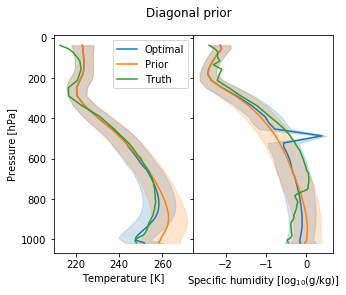

In [34]:
fig = supporting_routines.plotMwrResults(
    oe_diag,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Diagonal prior')



### Root mean square error
Which can be also seen by the increased RMS errors:



In [35]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Diagonal prior:')
supporting_routines.print_mwr_rms(oe_diag)


Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Diagonal prior:
RMS X Temperature: 2.42742 [K]
RMS X Humidity: 0.428865 [log$_{10}$(g/kg)]
RMS Y 0.0724113 [K]


### Statistical tests

Also all staistical tests fail in this case. In summary, the non-diagonal elements of  $\mathbb{S}_a$ are crucial for such an under constrained retrieval system.

In [36]:
print(oe_diag.chiSquareTest()[0])

Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


## Forward operator uncertainty

Finally, we concider the forward operator uncertainty as it was estimated by Cimini et al. (2018) $\mathbb{S}_{yb}$ in $\mathbf{y}$ space:

In [37]:
S_yb = pn.DataFrame(
    np.array([
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]),
    index=frequencies[::-1],
    columns=frequencies)

Text(0.5, 1.0, 'Model uncertainty in $\\mathbf{y}$ space (Cimini et al. 2018)')

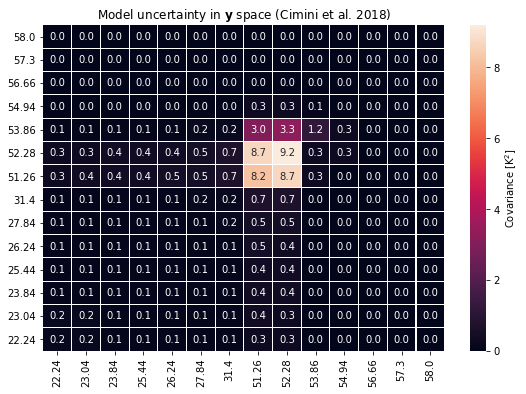

In [38]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_yb, 
    annot=True, 
    linewidths=.05, 
    ax=ax, 
    fmt='.1f', 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title('Model uncertainty in $\mathbf{y}$ space (Cimini et al. 2018)')

To run the retrieval, we combine $\mathbb{S}_{yb}$ and $\mathbb{S}_{y}$. The retireval converges after only one iteration, but the degrees of freedom are reduced from 3.68 to 3.28 highlighting that soem of the information retrieved by the refernece configuration cannot be trusted when considering foreward model uncertainties. 

In [39]:
x_a = x_mean.sel(season='MAM').to_pandas()
S_a = x_cov.sel(season='MAM').to_pandas()

oe_b = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y + S_yb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b.doRetrieval()


11.13 s, iteration 1, degrees of freedom: 3.81 of 120. convergence criteria NOT fullfilled  10.278
16.87 s, iteration 2, degrees of freedom: 3.77 of 120. convergence criteria fullfilled  0.174
20.26 s, iteration 3, degrees of freedom: 3.77 of 120.  Done.  0.002


True

### Profiles
The vertical profiles look similar


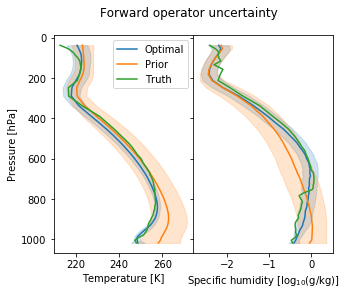

In [40]:
fig = supporting_routines.plotMwrResults(
    oe_b,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Forward operator uncertainty')


### Root mean square errors
The RMS errors are slightly reduced in comparison to the reference run.

In [41]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Concidering forward model error:')
supporting_routines.print_mwr_rms(oe_b)


Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Concidering forward model error:
RMS X Temperature: 2.28415 [K]
RMS X Humidity: 0.152141 [log$_{10}$(g/kg)]
RMS Y 0.17877 [K]


### Statistical tests
And all stastistical tests pass


In [42]:
print(oe_b.chiSquareTest()[0])

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 11 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


### Analyse uncertainties and degrees of freedom
Another way to compare different retrieval configurations is to look at the ratio between prior and posterior uncertainty and the degree of freedoms for each variable of $\mathbf{x}$

Change in degrees of freedom for temperature variables 0.449552
Change in degrees of freedom for humidity variables 0.446728


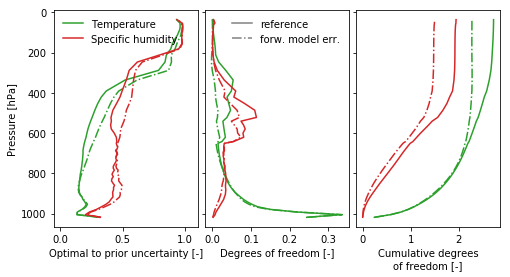

In [43]:
fig = supporting_routines.plot_uncertainty_dof(
    oe_ref, oe_b, 'forw. model err.',
    pressure.sel(season='MAM') / 100)

print('Change in degrees of freedom for temperature variables %g' %
      (supporting_routines.splitTQ(oe_ref.dgf_x)[0].sum() -
       supporting_routines.splitTQ(oe_b.dgf_x)[0].sum()))
print('Change in degrees of freedom for humidity variables %g' %
      (supporting_routines.splitTQ(oe_ref.dgf_x)[1].sum() -
       supporting_routines.splitTQ(oe_b.dgf_x)[1].sum()))

The relative reduction of uncertainty (left plot) can be derived from the ratio of the squared diagonales of $\mathbb{S}_{a}$ and $\mathbb{S}_{optimal}$. The $\mathbb{S}_{yb}$ of Cimini et al. (2018) introduced above has the highest values at the rather transparent V-band frequencies 51.26 and 52.28 GHz. Therefore, it is no surprise that considering  $\mathbb{S}_{yb}$ leads to the strongest effect for the temperature profile between 400 and 600 hPa.

This can be also seen in the reduction of the individual degrees of freedom (middle, i.e. `oe_ref.dgf_x`), which are derived from the diagonal of the averaging kernel $\mathbb{A}$ (the total degrees of freedom is the trace of $\mathbb{A}$) The reduction is particularly strong in the upper part of the atmosphere before the information content is reduced to zero above 200 hPa. 

When cumulating the individual degrees of freedom (right), this reduces the degrees of freedom for the temperature variables by 0.27. Even though the $\mathbb{S}_{yb}$ in the humidity sensitive K-band are small and the individual degrees of freedom are hardly reduced, the individual reductions sum up and the cumulated degrees of freedom for the humidity profile is also reduced by 0.16


## Reducing / increasing measurement uncertainty

In [44]:
x_a = x_mean.sel(season='MAM').to_pandas()
S_a = x_cov.sel(season='MAM').to_pandas()

oe_b_double = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    (S_y + S_yb) * 4,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b_double.doRetrieval()



10.73 s, iteration 1, degrees of freedom: 3.14 of 120. convergence criteria fullfilled  0.969
13.17 s, iteration 2, degrees of freedom: 3.13 of 120.  Done.  0.009


True

In [45]:
x_a = x_mean.sel(season='MAM').to_pandas()
S_a = x_cov.sel(season='MAM').to_pandas()

oe_b_half = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    (S_y + S_yb) / 4,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b_half.doRetrieval()




6.10 s, iteration 1, degrees of freedom: 4.60 of 120. convergence criteria NOT fullfilled  122.015
10.09 s, iteration 2, degrees of freedom: 4.54 of 120. convergence criteria NOT fullfilled  2.496
12.42 s, iteration 3, degrees of freedom: 4.53 of 120. convergence criteria fullfilled  0.013
14.57 s, iteration 4, degrees of freedom: 4.53 of 120.  Done.  0.000


True

### Degrees of freedom

In [46]:
print('Change in degrees of freedom when dividing by two %g' %
      (oe_b.dgf - oe_b_half.dgf))
print('Change in degrees of freedom when multiplying by two %g' %
      (oe_b.dgf - oe_b_doubled.dgf))



Change in degrees of freedom when dividing by two -0.761211


NameError: name 'oe_b_doubled' is not defined

### Profiles

In [ ]:
fig = supporting_routines.plotMwrResults(
    oe_b_doubled,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Doubled Sy')

fig = supporting_routines.plotMwrResults(
    oe_b_half,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Half Sy')




### Root mean square errors

In [ ]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_b)
print('Concidering forward model error:')
supporting_routines.print_mwr_rms(oe_b_doubled)
print('Concidering forward model error and non-diagonal elements in Sy:')
supporting_routines.print_mwr_rms(oe_b_half)




### Statistical tests
All statistical tests pass for both versions

In [ ]:
print(oe_b_double.chiSquareTest()[0]), print(oe_b_half.chiSquareTest()[0])

###  Analyze uncertainties and degrees of freedom



In [ ]:

fig = supporting_routines.plot_uncertainty_dof(
    oe_b, oe_b_doubled, 'Sy doubled',
    pressure.sel(season='MAM') / 100,
    oe3=oe_b_half, label3 = 'Sy half'
)



## Consider non-diagonal elements of the measurement uncertainty

So far, we assumed that the measurement errors of the various microwave channels are not correlated. In reality, this is not the case because of hardware limitations. In the following, we investigate the impact of considering the non-diagonal elements **in addition** to the forward model uncertainty introduced above.

We define $\mathbb{S}_{y}$ as follows (REFERENCE!!)

In [ ]:
S_y_nondiag = np.array(
    [[
        1.4464e-02, 3.1175e-03, 3.2584e-03, 2.7590e-03, 2.1494e-03, 1.8121e-03,
        2.3444e-03, -2.8253e-03, -1.1941e-03, -7.1487e-04, -7.1019e-05,
        -1.3676e-04, -3.0526e-04, -3.8639e-03
    ],
     [
         3.1175e-03, 1.1803e-02, 2.5663e-03, 2.1457e-03, 1.5946e-03,
         1.6916e-03, 1.8975e-03, -7.3124e-04, -4.7555e-04, 1.8126e-04,
         -8.1855e-04, 4.6114e-04, 3.1963e-06, -2.5867e-03
     ],
     [
         3.2584e-03, 2.5663e-03, 1.0841e-02, 2.3239e-03, 1.1311e-03,
         1.1062e-03, 1.5767e-03, -6.4790e-04, -1.3201e-03, 1.7669e-04,
         -1.0165e-03, -4.5220e-04, -5.8443e-04, -1.9019e-03
     ],
     [
         2.7590e-03, 2.1457e-03, 2.3239e-03, 8.4360e-03, 1.3579e-03,
         1.5264e-03, 1.4780e-03, -8.7548e-04, -1.5626e-03, -1.7332e-04,
         -4.6437e-04, -1.8432e-04, -1.7265e-04, -3.8433e-03
     ],
     [
         2.1494e-03, 1.5946e-03, 1.1311e-03, 1.3579e-03, 1.0352e-02,
         3.3218e-03, 3.1755e-03, -2.2734e-03, -2.3389e-03, -1.2198e-03,
         -7.2950e-04, 2.0710e-04, 2.5822e-04, -5.9091e-03
     ],
     [
         1.8121e-03, 1.6916e-03, 1.1062e-03, 1.5264e-03, 3.3218e-03,
         1.0172e-02, 3.2801e-03, -2.0768e-03, -2.1563e-03, -4.6483e-04,
         -1.6465e-03, 9.4358e-05, -2.8649e-04, -5.4612e-03
     ],
     [
         2.3444e-03, 1.8975e-03, 1.5767e-03, 1.4780e-03, 3.1755e-03,
         3.2801e-03, 1.1026e-02, -3.1658e-04, -1.1692e-03, -7.5206e-04,
         -1.0920e-03, -3.7627e-05, -2.0978e-04, -1.7690e-03
     ],
     [
         -2.8253e-03, -7.3124e-04, -6.4790e-04, -8.7548e-04, -2.2734e-03,
         -2.0768e-03, -3.1658e-04, 1.7896e-01, 7.2248e-02, 4.8262e-02,
         4.6481e-02, 1.6283e-02, 1.8456e-02, 1.6027e-01
     ],
     [
         -1.1941e-03, -4.7555e-04, -1.3201e-03, -1.5626e-03, -2.3389e-03,
         -2.1563e-03, -1.1692e-03, 7.2248e-02, 2.0847e-01, 2.8595e-02,
         2.9832e-02, 1.1226e-02, 1.3614e-02, 1.1240e-01
     ],
     [
         -7.1487e-04, 1.8126e-04, 1.7669e-04, -1.7332e-04, -1.2198e-03,
         -4.6483e-04, -7.5206e-04, 4.8262e-02, 2.8595e-02, 6.9126e-02,
         2.5361e-02, 1.3994e-02, 1.8141e-02, 5.6810e-02
     ],
     [
         -7.1019e-05, -8.1855e-04, -1.0165e-03, -4.6437e-04, -7.2950e-04,
         -1.6465e-03, -1.0920e-03, 4.6481e-02, 2.9832e-02, 2.5361e-02,
         6.5223e-02, 1.3962e-02, 1.6982e-02, 6.0963e-02
     ],
     [
         -1.3676e-04, 4.6114e-04, -4.5220e-04, -1.8432e-04, 2.0710e-04,
         9.4358e-05, -3.7627e-05, 1.6283e-02, 1.1226e-02, 1.3994e-02,
         1.3962e-02, 3.1456e-02, 1.7948e-02, 1.8197e-02
     ],
     [
         -3.0526e-04, 3.1963e-06, -5.8443e-04, -1.7265e-04, 2.5822e-04,
         -2.8649e-04, -2.0978e-04, 1.8456e-02, 1.3614e-02, 1.8141e-02,
         1.6982e-02, 1.7948e-02, 3.0822e-02, 2.1850e-02
     ],
     [
         -3.8639e-03, -2.5867e-03, -1.9019e-03, -3.8433e-03, -5.9091e-03,
         -5.4612e-03, -1.7690e-03, 1.6027e-01, 1.1240e-01, 5.6810e-02,
         6.0963e-02, 1.8197e-02, 2.1850e-02, 3.5390e-01
     ]])

S_y_nondiag = pn.DataFrame(
    S_y_nondiag,
    index=y_vars,
    columns=y_vars,
)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_y_nondiag, annot=True, fmt='.2f', ax=ax, linewidths=.05, cbar_kws={'label':'Covariance [K$^2$]'})

ax.set_title('Measurement uncertainty in $\mathbf{y}$ space including non-diagonal elements.')


In [ ]:
x_a = x_mean.sel(season='MAM').to_pandas()[x_vars]
S_a = x_cov.sel(season='MAM').to_pandas().loc[x_vars, x_vars]

oe_nondiag_b = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y_nondiag + S_yb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs
)
oe_nondiag_b.doRetrieval()

### Profiles
The retrieved vertical profiles look similar to the reference run 


In [ ]:
fig = supporting_routines.plotMwrResults(
    oe_nondiag_b,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Forward operator uncertainty')


### Root mean square errors
The RMS errors are slightly reduced in comparison to the reference run, but similar to the run considering the forward model error

In [ ]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Concidering forward model error:')
supporting_routines.print_mwr_rms(oe_nondiag_b)
print('Concidering forward model error and non-diagonal elements in Sy:')
supporting_routines.print_mwr_rms(oe_b)



### Statistical tests
All statistical tests pass


In [ ]:
print(oe_nondiag_b.chiSquareTest()[0])

### Analyse uncertainties and degrees of freedom
Another way to compare different retrieval configurations is to look at the ratio between prior and posterior uncertainty and the degree of freedoms for each variable of $\mathbf{x}$

In [ ]:

fig = supporting_routines.plot_uncertainty_dof(
    oe_ref, oe_b, 'forw. model err.',
    pressure.sel(season='MAM') / 100,
    oe3=oe_nondiag_b, label3 = '& non-diag $\mathbb{S}_y$'
)

print('Change in degrees of freedom for temperature variables %g' %
      (supporting_routines.splitTQ(oe_b.dgf_x)[0].sum() -
       supporting_routines.splitTQ(oe_nondiag_b.dgf_x)[0].sum()))
print('Change in degrees of freedom for humidity variables %g' %
      (supporting_routines.splitTQ(oe_b.dgf_x)[1].sum() -
       supporting_routines.splitTQ(oe_nondiag_b.dgf_x)[1].sum()))

# References

Cimini, D., P. W. Rosenkranz, M. Y. Tretyakov, M. A. Koshelev, and F. Romano, 2018: Uncertainty of atmospheric microwave absorption model: impact on ground-based radiometer simulations and retrievals. *Atmospheric Chemistry and Physics*, 18, 15231–15259, https://doi.org/10.5194/acp-18-15231-2018.

Löhnert, U., S. Crewell, and C. Simmer, 2004: An Integrated Approach toward Retrieving Physically Consistent Profiles of Temperature, Humidity, and Cloud Liquid Water. *J. Appl. Meteor.*, 43, 1295–1307, [https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2](https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2).

Rose, T., S. Crewell, U. Lohnert, and C. Simmer, 2005: A network suitable microwave radiometer for operational monitoring of the cloudy atmosphere. *Atmos. Res.*, 75, 183–200, https://doi.org/10.1016/j.atmosres.2004.12.005.  
  